In [1]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.miscmodels.ordinal_model import OrderedModel
import networkx as nx

pd.options.display.max_seq_items = 2000

# Two crs, one for coordinates and a projected one to compute areas
crs_geographical = "epsg:4326"
crs_projected = "epsg:28992"

# Confounder names
confounders = [ 
           "P_00_14_JR", 'P_15_24_JR','P_25_44_JR','P_45_64_JR', 'P_65_EO_JR',  # Age distribution
           'P_LAAGINKP', 'BEV_DICHTH', 'WWB_UITTOT', 'WW_UIT_TOT', 'AO_UIT_TOT' # Confounders
           ]

# Small number to add 
epsilon = 1e-8

In [2]:
def ReadData(filepath):
    # Read data
    gdf = gpd.read_file(filepath, 
                        GEOM_POSSIBLE_NAMES="geometry", # Having a column named 'geometry' is too hard for geopandas
                        KEEP_GEOM_COLUMNS="NO")

    # Don't ask me where this column came from
    gdf.drop(["field_1"], axis=1, inplace=True)

    gdf["DEPRESSION_RISK"] = gdf["DEPRESSION_RISK"].str.replace(',','.')

    # Set the columns as floats 
    for col in confounders + ["area", "percent_green", "percent_blue", "percent_greenblue", "DEPRESSION_RISK"]:
        gdf[col] = gdf[col].astype('float')

        # Normalize the column 
        gdf[col] = (gdf[col] - gdf[col].min()) / (gdf[col].max() - gdf[col].min())
        # print(gdf[col].min(), gdf[col].mean(), gdf[col].max() )
    return gdf

In [44]:
class PropensityMatching():
    def __init__(self,
                 name,
                 y,
                 z,
                 conf,
                 nlevels,
                 random_sample = False,
                 null = False
        ) -> None:

        self.name = name
        self.y = y.values
        self.z = z.values
        self.nlevels = nlevels
        if null:
            np.random.shuffle(self.z)
        if random_sample:
            self.z = np.random.random_sample(size=self.z.shape)
        self.null = null
        self.random_sample = random_sample
        self.conf = conf
        
        
    def CalculatePropensityScore(self, plot=False):
        if not self.random_sample:
            # We want to make the first bin really small, so it only has the zeroes
            edges = np.array([-0.000001] + list(np.linspace(0.00000001, self.z.max()+epsilon, self.nlevels)))
        else:
            # This is not nessecary when randomly sampling greenspace
            edges = np.linspace(0, self.z.max()+epsilon, self.nlevels+1)

        self.discrete= pd.cut(self.z, bins=edges, labels=np.arange(0,self.nlevels))
                
        if plot:
            # TODO: Make this look nice
            plt.hist(self.discrete, bins=self.nlevels)
            plt.show()
        
        mod_log = OrderedModel(self.z, self.conf, distr='logit')

        res_log = mod_log.fit(method='bfgs', disp=False)

        predicted = res_log.model.predict(res_log.params, exog=self.conf)

        self.propensity = np.array([predicted[i, self.discrete[i]] for i in range(len(self.z))])
        return self.propensity


    def DistanceMatrix(self):
        self.d = np.zeros(shape=(len(self.z), len(self.z)))

        dlist = []

        for i in range(self.d.shape[0]):
            for j in range(self.d.shape[1]):
                self.d[i,j] = (abs(self.propensity[i] - self.propensity[j])) / (abs(self.z[i] - self.z[j])+epsilon)
                dlist.append(abs(self.z[i] - self.z[j]))
        return self.d


    def MinWeightMaximalMatch(self):
        G = nx.Graph(self.d)
        match_unordered = nx.min_weight_matching(G)

        # array with low in col 0 and high in col 1
        self.match = np.zeros(shape=(len(match_unordered), 2), dtype=int)

        for idx, pair in enumerate(match_unordered):
            i = pair[0]
            j = pair[1]
            if self.z[i] < self.z[j]:
                self.match[idx,0] = i
                self.match[idx,1] = j
            else:
                self.match[idx,0] = j
                self.match[idx,1] = i
        return self.match


    def TreatmentEffect(self, threshold=None):
        self.TE = []
        for i, j in self.match:
            te = (self.y[i] - self.y[j])/(self.z[i] - self.z[j])
            if not threshold or abs(te) < threshold:
                self.TE.append(te)
        self.TE = np.array(self.TE)
        self.ATE = np.sum(self.TE)
        return self.TE, self.ATE
    
    
    def HighAndLowGroups(self, dec=4):
        matches = np.zeros(shape=(self.nlevels, self.nlevels))

        high = []
        low = []
        for i, j in self.match:
            low.append(self.z[i])
            high.append(self.z[j])
            level_low = self.discrete[i]
            level_high = self.discrete[j]
            matches[level_high, level_low] += 1

        plt.imshow(matches, origin='lower')
        plt.xlabel("Low dose unit")
        plt.ylabel("High dose unit")
        plt.title(f"Distribution of treatments per match")
        plt.show()

        print(f"Treatment distribution over high and low groups")
        print(f"High: mean={round(np.mean(high),dec)}, std={round(np.std(high),dec)}, min={round(np.min(high),dec)}, max={round(np.max(high),dec)}")
        print(f"Low: mean={round(np.mean(low),dec)}, std={round(np.std(low),dec)}, min={round(np.min(low),dec)}, max={round(np.max(low),dec)}")
    
    def DescribeTreatmentEffect(self, dec=3):
        print(f"{self.name } & {round(self.ATE, dec)} & {round(self.TE.min(), dec)} & {round(np.percentile(self.TE, 25), dec)} & {round(np.percentile(self.TE, 75), dec)} & {round(self.TE.max(), dec)} \\\\")        


/home/levi/.local/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]


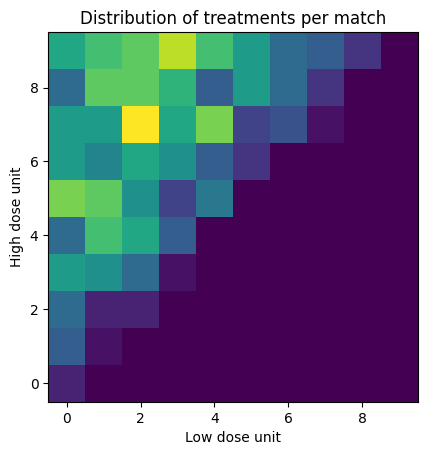

Treatment distribution over high and low groups
High: mean=0.7036, std=0.2155, min=0.0839, max=0.998
Low: mean=0.275, std=0.1907, min=0.0009, max=0.8787


-3.2061305887503098

In [46]:
# Run the process with randomly sampled greenspace to show the matching works
gdf = ReadData("data/prepared_data.csv")

green_random = PropensityMatching(
    "Green Random",
    gdf["DEPRESSION_RISK"], 
    gdf['percent_green'],
    gdf[confounders+["percent_blue"]],
    10,
    random_sample=True
)
green_random.CalculatePropensityScore()
green_random.DistanceMatrix()
green_random.MinWeightMaximalMatch()
green_random.TreatmentEffect()
green_random.HighAndLowGroups()
green_random.ATE

In [36]:
green_random.DescribeTreatmentEffect()

Green Random
            & 213.266
            & -392.418
            & -2.548
            & 3.837
            & 1101.555
            \\


[1, 1, 1, 1, 1, ..., 0, 0, 0, 0, 2]
Length: 899
Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]
899


/home/levi/.local/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]


0.0 1.0


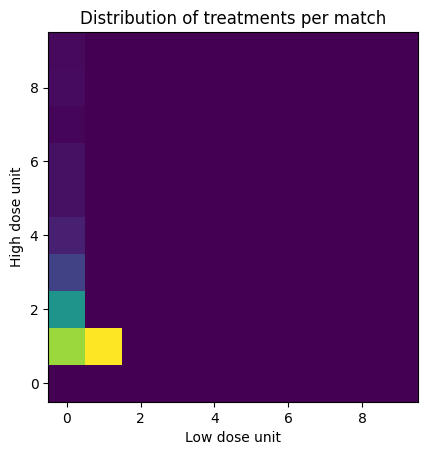

Treatment distribution over high and low groups
High: mean=0.1198, std=0.1687, min=0.0005, max=1.0
Low: mean=0.0009, std=0.0019, min=0.0, max=0.0138


213.26587362395531

In [37]:
# Run the process for greenspace
gdf = ReadData("data/prepared_data.csv")

green = PropensityMatching(
    "Green",
    gdf["DEPRESSION_RISK"], 
    gdf['percent_green'],
    gdf[confounders+["percent_blue"]],
    10,
)
green.CalculatePropensityScore()
green.DistanceMatrix()
green.MinWeightMaximalMatch()
green.TreatmentEffect()
green.HighAndLowGroups()
green.ATE

[1, 1, 1, 1, 1, ..., 0, 1, 0, 1, 1]
Length: 899
Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]
899


/home/levi/.local/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]


0.0 1.0


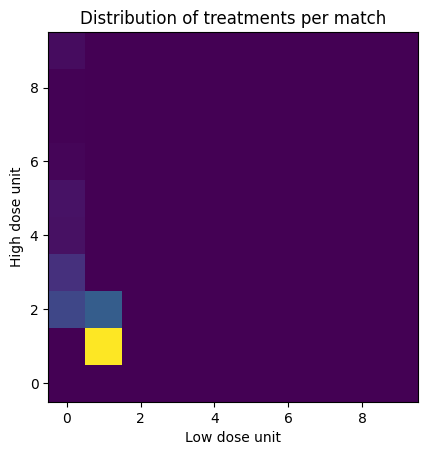

Treatment distribution over high and low groups
High: mean=0.1502, std=0.1616, min=0.0173, max=1.0
Low: mean=0.0227, std=0.0237, min=0.0, max=0.1014


-660.4107606825913

In [38]:
# Run the process for bluespace
gdf = ReadData("data/prepared_data.csv")

blue = PropensityMatching(
    "Blue",
    gdf["DEPRESSION_RISK"], 
    gdf['percent_blue'],
    gdf[confounders+["percent_green"]],
    10,
)
blue.CalculatePropensityScore()
blue.DistanceMatrix()
blue.MinWeightMaximalMatch()
blue.TreatmentEffect()
blue.HighAndLowGroups()
blue.ATE

[1, 1, 1, 1, 1, ..., 0, 0, 0, 0, 1]
Length: 899
Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]
899


/home/levi/.local/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]


0.0 1.0


/tmp/ipykernel_34889/65853879.py:87: RuntimeWarning: divide by zero encountered in double_scalars
  te = (self.y[i] - self.y[j])/(self.z[i] - self.z[j])
/home/levi/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


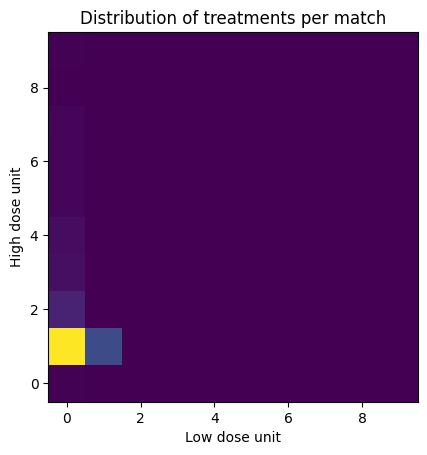

Treatment distribution over high and low groups
High: mean=0.0696, std=0.1422, min=0.0, max=1.0
Low: mean=0.0, std=0.0001, min=0.0, max=0.0006


nan

In [39]:
# Run the process for blue- and greenspace
gdf = ReadData("data/prepared_data.csv")

bluegreen = PropensityMatching(
    "Blue*Green",
    gdf["DEPRESSION_RISK"], 
    gdf['percent_greenblue'],
    gdf[confounders],
    10,
)
bluegreen.CalculatePropensityScore()
bluegreen.DistanceMatrix()
bluegreen.MinWeightMaximalMatch()
bluegreen.TreatmentEffect()
bluegreen.HighAndLowGroups()
bluegreen.ATE

[1, 1, 1, 1, 0, ..., 0, 0, 1, 1, 1]
Length: 899
Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]
899


/home/levi/.local/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]


0.0 1.0


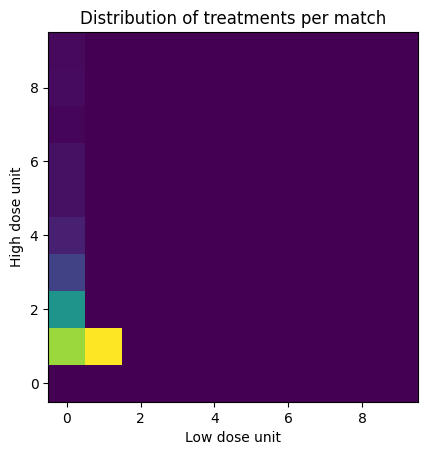

Treatment distribution over high and low groups
High: mean=0.1197, std=0.1688, min=0.001, max=1.0
Low: mean=0.001, std=0.0021, min=0.0, max=0.0168


-2390.087919383359

In [40]:
# Run the process for greenspace null
gdf = ReadData("data/prepared_data.csv")

greennull = PropensityMatching(
    "Green Null",
    gdf["DEPRESSION_RISK"], 
    gdf['percent_green'],
    gdf[confounders+["percent_blue"]],
    10,
    null = True
)
greennull.CalculatePropensityScore()
greennull.DistanceMatrix()
greennull.MinWeightMaximalMatch()
greennull.TreatmentEffect()
greennull.HighAndLowGroups()
greennull.ATE

[5, 1, 2, 1, 1, ..., 1, 1, 1, 0, 1]
Length: 899
Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]
899


/home/levi/.local/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]


0.0 1.0


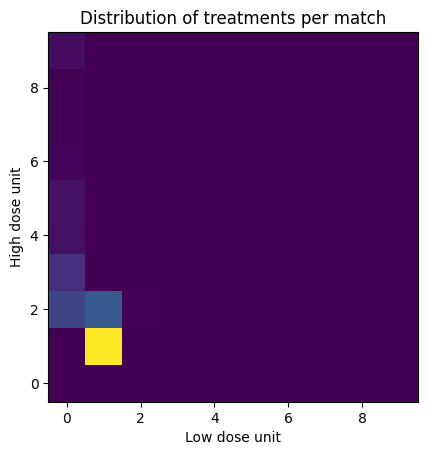

Treatment distribution over high and low groups
High: mean=0.1513, std=0.1609, min=0.0187, max=1.0
Low: mean=0.0216, std=0.0223, min=0.0, max=0.1175


-52.16629360213501

In [41]:
# Run the process for bluespace null
gdf = ReadData("data/prepared_data.csv")

bluenull = PropensityMatching(
    "Blue Null",
    gdf["DEPRESSION_RISK"], 
    gdf['percent_blue'],
    gdf[confounders+["percent_green"]],
    10,
    null = True
)
bluenull.CalculatePropensityScore()
bluenull.DistanceMatrix()
bluenull.MinWeightMaximalMatch()
bluenull.TreatmentEffect()
bluenull.HighAndLowGroups()
bluenull.ATE

[1, 0, 0, 1, 0, ..., 1, 0, 1, 0, 1]
Length: 899
Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]
899


/home/levi/.local/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]


0.0 1.0


/tmp/ipykernel_34889/65853879.py:87: RuntimeWarning: divide by zero encountered in double_scalars
  te = (self.y[i] - self.y[j])/(self.z[i] - self.z[j])
/home/levi/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


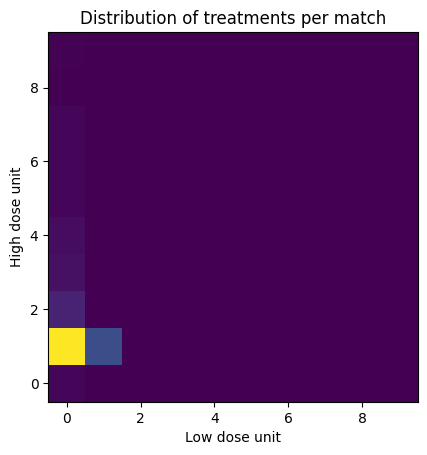

Treatment distribution over high and low groups
High: mean=0.0696, std=0.1422, min=0.0, max=1.0
Low: mean=0.0, std=0.0001, min=0.0, max=0.0009


nan

In [42]:
# Run the process for blue- and greenspace null
gdf = ReadData("data/prepared_data.csv")

bluegreennull = PropensityMatching(
    "Blue*Green Null",
    gdf["DEPRESSION_RISK"], 
    gdf['percent_greenblue'],
    gdf[confounders],
    10,
    null = True
)
bluegreennull.CalculatePropensityScore()
bluegreennull.DistanceMatrix()
bluegreennull.MinWeightMaximalMatch()
bluegreennull.TreatmentEffect()
bluegreennull.HighAndLowGroups()
bluegreennull.ATE

In [45]:
# Print all of the ATE's in nice latex format

green.DescribeTreatmentEffect()
blue.DescribeTreatmentEffect()
bluegreen.DescribeTreatmentEffect()
greennull.DescribeTreatmentEffect()
bluenull.DescribeTreatmentEffect()
bluegreennull.DescribeTreatmentEffect()


Green
            & 213.266
            & -392.418
            & -2.548
            & 3.837
            & 1101.555
            \\
Blue
            & -660.411
            & -300.181
            & -1.799
            & 2.325
            & 103.204
            \\
Blue*Green
            & nan
            & -inf
            & -12.368
            & 8.516
            & inf
            \\
Green Null
            & -2390.088
            & -1272.6
            & -3.456
            & 3.152
            & 264.494
            \\
Blue Null
            & -52.166
            & -157.423
            & -1.931
            & 1.932
            & 51.409
            \\
Blue*Green Null
            & nan
            & -inf
            & -7.524
            & 12.148
            & inf
            \\
